In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import random

In [2]:
class GoProDataset(Dataset):
    def __init__(self, root_dir , phase='train' , crop_size=256 , augment=True):
        self.root_dir = os.path.join(root_dir , phase)
        self.blur_dir = os.path.join(self.root_dir , 'blur')  # Use glob for subdirs
        self.sharp_dir = os.path.join(self.root_dir , 'sharp')
        self.blur_files = os.listdir(self.blur_dir)
        self.crop_size = crop_size
        self.augment = augment

    def __len__(self):
        return len(self.blur_files)

    def __getitem__(self,idx):
        subdir = self.blur_files[idx]
        blur_path = os.path.join(self.blur_dir,subdir)
        sharp_path = os.path.join(self.sharp_dir,subdir)

        
        blur_img = cv2.imread(blur_path)
        blur_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB)
        blur_img = blur_img/255.0
        sharp_img = cv2.imread(sharp_path)
        sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2RGB)
        sharp_img = sharp_img/255.0

        h,w = blur_img.shape[:2]
        x = random.randint(0,w-self.crop_size)
        y = random.randint(0,h-self.crop_size)

        blur_crop = blur_img[y:y+self.crop_size,x:x+self.crop_size]
        sharp_crop = sharp_img[y:y+self.crop_size,x:x+self.crop_size]

        if self.augment:
            if random.random() > 0.5:
                blur_crop = np.fliplr(blur_crop)
                sharp_crop = np.fliplr(sharp_crop)
                
        blur_tensor = torch.from_numpy(blur_crop.transpose(2,0,1).copy()).float()
        sharp_crop = torch.from_numpy(sharp_crop.transpose(2,0,1).copy()).float()
        blur_tensor = blur_tensor * 2 - 1
        sharp_crop = sharp_crop * 2 - 1
        return blur_tensor,sharp_crop

train_dataset = GoProDataset('/kaggle/input/Gopro', phase='train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

In [3]:
# Create the validation dataset, pointing to the 'test' directory
val_dataset = GoProDataset('/kaggle/input/Gopro', phase='test')

# Create the validation loader
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

=== DATA VALIDATION ===
Blur tensor shape: torch.Size([3, 256, 256])
Sharp tensor shape: torch.Size([3, 256, 256])
Blur range: -0.710 to 0.255
Sharp range: -1.000 to 0.631
Blur mean: -0.162
Sharp mean: -0.170
Blur std: 0.241
Sharp std: 0.264


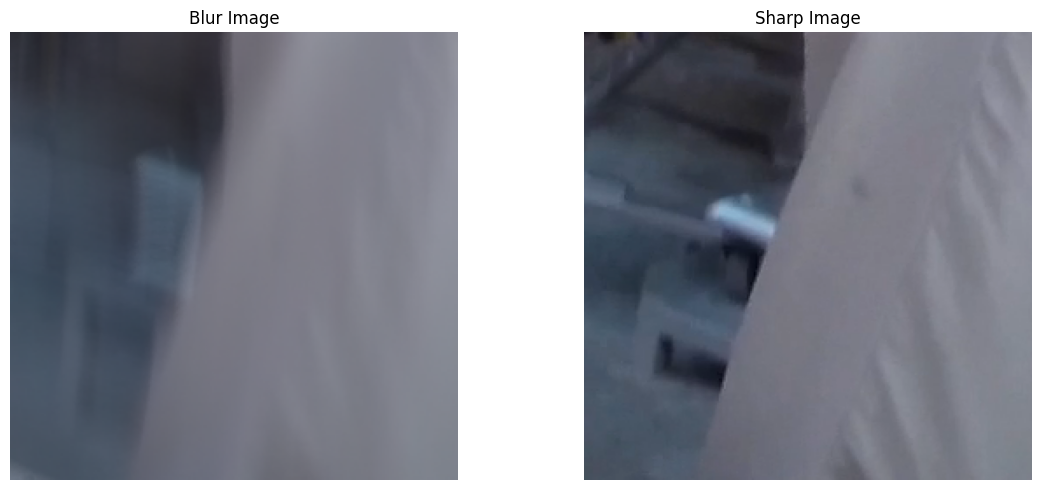


=== TESTING MULTIPLE SAMPLES ===
Sample 0: Blur range [-0.216, 0.710], Sharp range [-0.788, 0.757]
Sample 1: Blur range [-0.961, 0.835], Sharp range [-1.000, 0.875]
Sample 2: Blur range [-0.686, 1.000], Sharp range [-0.953, 1.000]

=== DATALOADER TEST ===
Batch blur shape: torch.Size([4, 3, 256, 256])
Batch sharp shape: torch.Size([4, 3, 256, 256])
Batch blur range: [-0.976, 1.000]
Batch sharp range: [-1.000, 1.000]

✅ If all ranges are [-1, 1] and images look normal, your data is good!


In [4]:
# Add this right after creating your dataset to verify everything is working

# 1. Test single sample
blur_tensor, sharp_tensor = train_dataset[0]

print("=== DATA VALIDATION ===")
print(f"Blur tensor shape: {blur_tensor.shape}")
print(f"Sharp tensor shape: {sharp_tensor.shape}")
print(f"Blur range: {blur_tensor.min().item():.3f} to {blur_tensor.max().item():.3f}")
print(f"Sharp range: {sharp_tensor.min().item():.3f} to {sharp_tensor.max().item():.3f}")

# 2. Check if tensors are not all zeros/ones
print(f"Blur mean: {blur_tensor.mean().item():.3f}")
print(f"Sharp mean: {sharp_tensor.mean().item():.3f}")
print(f"Blur std: {blur_tensor.std().item():.3f}")
print(f"Sharp std: {sharp_tensor.std().item():.3f}")

# 3. Visualize samples to make sure they look right
import matplotlib.pyplot as plt

def denormalize(tensor):
    """Convert from [-1,1] back to [0,1] for visualization"""
    return (tensor + 1) / 2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Convert CHW to HWC and denormalize
blur_img = denormalize(blur_tensor).permute(1, 2, 0).numpy()
sharp_img = denormalize(sharp_tensor).permute(1, 2, 0).numpy()

axes[0].imshow(blur_img)
axes[0].set_title('Blur Image')
axes[0].axis('off')

axes[1].imshow(sharp_img)
axes[1].set_title('Sharp Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 4. Test multiple samples to ensure consistency
print("\n=== TESTING MULTIPLE SAMPLES ===")
for i in range(3):
    blur_t, sharp_t = train_dataset[i]
    print(f"Sample {i}: Blur range [{blur_t.min():.3f}, {blur_t.max():.3f}], Sharp range [{sharp_t.min():.3f}, {sharp_t.max():.3f}]")

# 5. Test dataloader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)  # num_workers=0 for debugging
batch_blur, batch_sharp = next(iter(train_loader))

print(f"\n=== DATALOADER TEST ===")
print(f"Batch blur shape: {batch_blur.shape}")
print(f"Batch sharp shape: {batch_sharp.shape}")
print(f"Batch blur range: [{batch_blur.min():.3f}, {batch_blur.max():.3f}]")
print(f"Batch sharp range: [{batch_sharp.min():.3f}, {batch_sharp.max():.3f}]")

print("\n✅ If all ranges are [-1, 1] and images look normal, your data is good!")

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
    A standard residual block with two convolutional layers.
    """
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1),
            nn.BatchNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class SelfAttention(nn.Module):
    """ 
    Self-attention layer (SAGAN).
    You can swap this with your own spatial, channel, or grid implementations.
    """
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        out = self.gamma * out + x
        return out

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Skip connection
        out = self.relu(out)
        return out

class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.query_conv = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # Generate query, key, value
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        value = self.value_conv(x).view(batch_size, -1, width * height)
        
        # Attention mechanism
        attention = torch.bmm(query, key)
        attention = self.softmax(attention)
        
        # Apply attention to values
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        
        # Residual connection with learnable weight
        out = self.gamma * out + x
        return out

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        
        # Encoder layers
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Enhanced bottleneck with residual blocks and attention
        self.bottleneck_res = nn.Sequential(
            ResidualBlock(512),
            ResidualBlock(512),
            ResidualBlock(512)
        )
        self.bottleneck_attn = SelfAttention(512)
        
        # Decoder layers with residual enhancement
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.dec1_res = ResidualBlock(1024)  # 512 + 512 from skip
        
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.dec2_res = ResidualBlock(512)   # 256 + 256 from skip
        self.dec2_attention = SelfAttention(512)
        
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.dec3_res = ResidualBlock(256)   # 128 + 128 from skip
        
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dec4_res = ResidualBlock(128)   # 64 + 64 from skip
        
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Output layer
        self.out = nn.Conv2d(64, 3, kernel_size=1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)        # 64 channels
        e2 = self.enc2(e1)       # 128 channels  
        e3 = self.enc3(e2)       # 256 channels
        e4 = self.enc4(e3)       # 512 channels
        e5 = self.enc5(e4)       # 512 channels
        
        # Enhanced bottleneck processing
        bott = self.bottleneck_res(e5)
        bott = self.bottleneck_attn(bott)
        
        # Decoder path with enhanced skip connections
        d1 = self.dec1(bott)                    # 512 channels
        d1_skip = torch.cat([d1, e4], dim=1)    # 1024 channels
        d1_skip = self.dec1_res(d1_skip)        # Enhanced with residuals
        
        d2 = self.dec2(d1_skip)                 # 256 channels
        d2_skip = torch.cat([d2, e3], dim=1)    # 512 channels (256*2)
        d2_skip = self.dec2_res(d2_skip)        # Enhanced with residuals
        d2_skip = self.dec2_attention(d2_skip)  # Spatial attention for detail focus
        
        d3 = self.dec3(d2_skip)                 # 128 channels
        d3_skip = torch.cat([d3, e2], dim=1)    # 256 channels (128*2)
        d3_skip = self.dec3_res(d3_skip)        # Enhanced with residuals
        
        d4 = self.dec4(d3_skip)                 # 64 channels
        d4_skip = torch.cat([d4, e1], dim=1)    # 128 channels
        d4_skip = self.dec4_res(d4_skip)        # Enhanced with residuals
        
        d5 = self.dec5(d4_skip)                 # 64 channels
        
        # Final output
        out = self.out(d5)
        return self.tanh(out)

In [7]:
class NLayerDiscrimnator(nn.Module):
    def __init__(self, input_nc=6, ndf=32, n_layers=3):  # Reduced ndf from 64 to 32
        super(NLayerDiscrimnator, self).__init__()
        
        # First layer with spectral norm and dropout
        layers = [
            nn.utils.spectral_norm(nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1)),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(0.2, True)
        ]
        
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            # Use stride=1 for layers 3+ to prevent over-downsampling
            stride = 2 if n <= 2 else 1
            layers += [
                nn.utils.spectral_norm(nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=stride, padding=1)),
                nn.Dropout2d(0.4),  # Removed BatchNorm, added dropout
                nn.LeakyReLU(0.2, True)
            ]
        
        # Final layers before output
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        layers += [
            nn.utils.spectral_norm(nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=1, padding=1)),
            nn.Dropout2d(0.7),  # Higher dropout before output, removed BatchNorm
            nn.LeakyReLU(0.2, True)
        ]
        
        # Output layer
        layers += [nn.utils.spectral_norm(nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1))]
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

class MultiScaleDiscriminator(nn.Module):
    def __init__(self, input_nc=6, ndf=32, n_layers=3, num_d=2):  # Updated ndf default
        super(MultiScaleDiscriminator, self).__init__()
        self.num_d = num_d
        for i in range(num_d):
            net_d = NLayerDiscrimnator(input_nc, ndf, n_layers)
            setattr(self, 'discriminator_' + str(i), net_d)
            
    def forward(self, blurry, sharp):
        x = torch.cat([blurry, sharp], dim=1)
        outputs = []
        for i in range(self.num_d):
            net_d = getattr(self, 'discriminator_' + str(i))
            outputs.append(net_d(x))
            # Downsample for the next discriminator
            x = F.avg_pool2d(x, kernel_size=3, stride=2, padding=[1, 1], count_include_pad=False)
        return outputs

In [8]:
gen = UNetGenerator().cuda()
disc = MultiScaleDiscriminator().cuda()

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.nn.functional import binary_cross_entropy_with_logits as bce

In [10]:
from torchvision import models

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
        self.vgg_layers = nn.Sequential(*[vgg[i] for i in range(36)]).eval()
        for param in self.vgg_layers.parameters():
            param.requires_grad = False
        self.loss = nn.L1Loss()

    def forward(self, generated, target):
        generated_norm = (generated + 1) / 2
        target_norm = (target + 1) / 2
        
        # Add ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(generated.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(generated.device)
        
        generated_norm = (generated_norm - mean) / std
        target_norm = (target_norm - mean) / std
        
        vgg_generated = self.vgg_layers(generated_norm)
        vgg_target = self.vgg_layers(target_norm)
        return self.loss(vgg_generated, vgg_target)

In [11]:
import torch.optim as optim

In [12]:
# Quick leak check
import os
train_files = set(os.listdir('/kaggle/input/Gopro/train/blur'))  
val_files = set(os.listdir('/kaggle/input/Gopro/test/blur'))
overlap = train_files.intersection(val_files)
print(f"Direct file overlap: {len(overlap)}")

Direct file overlap: 1111


In [13]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

class AdaptiveHyperparams:
    def __init__(self):
        self.lambda_l1 = 5.0
        self.lambda_gan = 1.0
        self.disc_train_freq = 10  # Start with 3:1 ratio (gen:disc)
        self.loss_history = {'gen': [], 'disc': []}
        self.disc_accuracy_history = []
        self.stagnation_counter = 0
        
    def update_weights(self, gen_loss, disc_loss, disc_accuracy):
        self.loss_history['gen'].append(gen_loss)
        self.loss_history['disc'].append(disc_loss)
        self.disc_accuracy_history.append(disc_accuracy)
        
        if len(self.loss_history['gen']) > 10:
            self.loss_history['gen'] = self.loss_history['gen'][-10:]
            self.loss_history['disc'] = self.loss_history['disc'][-10:]
            self.disc_accuracy_history = self.disc_accuracy_history[-10:]
        
        if len(self.loss_history['gen']) >= 3:
            gen_trend = np.mean(self.loss_history['gen'][-3:])
            disc_trend = np.mean(self.loss_history['disc'][-3:])
            loss_ratio = gen_trend / (disc_trend + 1e-8)
            
            if loss_ratio > 2.5:
                self.lambda_gan = min(self.lambda_gan * 1.02, 3.0)
                self.lambda_l1 = max(self.lambda_l1 * 0.98, 2.0)
            elif loss_ratio < 0.5:
                self.lambda_gan = max(self.lambda_gan * 0.95, 0.2)
                self.lambda_l1 = min(self.lambda_l1 * 1.05, 15.0)
    
    def update_training_freq(self, disc_accuracy):
        # More aggressive thresholds to react faster
        if disc_accuracy > 0.75:  # Lower threshold - react faster
            self.disc_train_freq = min(self.disc_train_freq + 1, 5)
        elif disc_accuracy < 0.45:  # Higher threshold - be more aggressive
            self.disc_train_freq = max(self.disc_train_freq - 1, 2)  # Never go below 2:1

def calculate_discriminator_accuracy(disc_outputs_real, disc_outputs_fake):
    with torch.no_grad():
        real_correct = sum([(pred > 0).float().mean() for pred in disc_outputs_real])
        fake_correct = sum([(pred < 0).float().mean() for pred in disc_outputs_fake])
        total_correct = (real_correct + fake_correct) / (len(disc_outputs_real) + len(disc_outputs_fake))
        return total_correct.item()

def compute_gradient_penalty(disc, blur, sharp, fake):
    alpha = torch.rand(sharp.size(0), 1, 1, 1).to(device).expand_as(sharp)
    interpolates = alpha * sharp + (1 - alpha) * fake
    interpolates.requires_grad = True
    disc_interpolates = disc(blur, interpolates)
    gp = 0
    for pred in disc_interpolates:
        gradients = torch.autograd.grad(outputs=pred, inputs=interpolates,
                                        grad_outputs=torch.ones_like(pred),
                                        create_graph=True, retain_graph=True)[0]
        gp += ((gradients.norm(2, dim=[1,2,3]) - 1) ** 2).mean()
    return gp / len(disc_interpolates)

def denormalize(tensor):
    return (tensor.permute(1, 2, 0).cpu().numpy() + 1) / 2

# --- Model, Loss, and Optimizer Initialization ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen = UNetGenerator().to(device)
disc = MultiScaleDiscriminator(ndf=16, n_layers=2).to(device)
perceptual_loss = VGGPerceptualLoss().to(device)

# Different optimizers for each network
gen_opt = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_opt = optim.RMSprop(disc.parameters(), lr=5e-5)  # RMSprop for discriminator

# Learning rate schedulers - discriminator decays faster
gen_scheduler = optim.lr_scheduler.ExponentialLR(gen_opt, gamma=0.98)  # Slow decay
disc_scheduler = optim.lr_scheduler.ExponentialLR(disc_opt, gamma=0.92)  # Faster decay

l1_loss = nn.L1Loss()

# Use adaptive hyperparameters
lambda_perceptual = 1.0
lambda_gp = 10.0  # For WGAN-GP

# --- Hyperparameters ---
num_epochs = 30  # Can reduce to 5 for testing

# Initialize adaptive hyperparameters
adaptive_hp = AdaptiveHyperparams()

# Get initial values from adaptive system
lambda_l1 = adaptive_hp.lambda_l1
lambda_gan = adaptive_hp.lambda_gan
disc_train_freq = adaptive_hp.disc_train_freq

# --- Training ---
for epoch in range(num_epochs):
    gen.train()
    disc.train()
    
    # Initialize epoch accumulators
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    epoch_disc_accuracy = 0.0
    step = 0
    
    # --- Training Loop ---
    for blur, sharp in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        blur, sharp = blur.to(device), sharp.to(device)
        
        # Generate fake images
        fake = gen(blur)
        
        # --- Train Discriminator (every disc_train_freq steps) ---
        if step % disc_train_freq == 0:
            disc_opt.zero_grad()
            
            # Clean inputs - no noise
            # Real loss (WGAN)
            d_real_preds = disc(blur, sharp)
            loss_d_real = 0
            for pred in d_real_preds:
                loss_d_real += -torch.mean(pred)
            
            # Fake loss (WGAN)
            d_fake_preds = disc(blur, fake.detach())
            loss_d_fake = 0
            for pred in d_fake_preds:
                loss_d_fake += torch.mean(pred)
                
            # Gradient Penalty
            gp = compute_gradient_penalty(disc, blur, sharp, fake.detach())
            
            loss_d = (loss_d_real + loss_d_fake) / len(d_real_preds) + lambda_gp * gp
            loss_d.backward()
            torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm=0.5)
            disc_opt.step()
            
            # Accumulate discriminator loss
            epoch_disc_loss += loss_d.item()
            
            # Calculate discriminator accuracy for this batch (adapted for WGAN)
            disc_accuracy = calculate_discriminator_accuracy(d_real_preds, d_fake_preds)
            epoch_disc_accuracy += disc_accuracy
        else:
            # Still need to calculate accuracy even when not training discriminator
            with torch.no_grad():
                d_real_preds = disc(blur, sharp)
                d_fake_preds = disc(blur, fake.detach())
                disc_accuracy = calculate_discriminator_accuracy(d_real_preds, d_fake_preds)
                epoch_disc_accuracy += disc_accuracy
        
        # --- Train Generator (every step) ---
        gen_opt.zero_grad()
        d_fake_gen_preds = disc(blur, fake)
        
        # GAN Loss (WGAN)
        loss_g_gan = 0
        for pred in d_fake_gen_preds:
            loss_g_gan += -torch.mean(pred)
        loss_g_gan /= len(d_fake_gen_preds)
        
        # L1 Loss
        loss_g_l1 = l1_loss(fake, sharp)
        
        # Perceptual Loss
        loss_g_perceptual = perceptual_loss(fake, sharp)
        
        # Combined Generator Loss
        loss_g = (lambda_gan * loss_g_gan) + (lambda_l1 * loss_g_l1) + (lambda_perceptual * loss_g_perceptual)
        
        loss_g.backward()
        torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=0.5)
        gen_opt.step()
        
        # Accumulate generator loss
        epoch_gen_loss += loss_g.item()
        
        step += 1
    
    # Learning rate scheduling - discriminator decays faster
    gen_scheduler.step()
    disc_scheduler.step()
    
    # Calculate epoch averages
    avg_gen_loss = epoch_gen_loss / len(train_loader)
    avg_disc_loss = epoch_disc_loss / max(1, len(train_loader) // disc_train_freq)
    avg_disc_accuracy = epoch_disc_accuracy / len(train_loader)
    
    # --- Validation Loop ---
    gen.eval()
    disc.eval()
    val_loss_d_avg = 0.0
    val_loss_g_avg = 0.0
    val_psnr_avg = 0.0
    val_ssim_avg = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for i, (blur_val, sharp_val) in enumerate(tqdm(val_loader, desc=f"Validating Epoch {epoch}")):
            blur_val, sharp_val = blur_val.to(device), sharp_val.to(device)
            fake_val = gen(blur_val)
            
            # Discriminator validation loss (WGAN style, no GP)
            d_real_preds_val = disc(blur_val, sharp_val)
            d_fake_preds_val = disc(blur_val, fake_val)
            loss_d_real_val = 0
            for pred in d_real_preds_val: 
                loss_d_real_val += -torch.mean(pred)
            loss_d_fake_val = 0
            for pred in d_fake_preds_val: 
                loss_d_fake_val += torch.mean(pred)
            val_loss_d_avg += (loss_d_real_val + loss_d_fake_val) / len(d_real_preds_val)
            
            # Generator validation loss
            d_fake_gen_preds_val = disc(blur_val, fake_val)
            loss_g_gan_val = 0
            for pred in d_fake_gen_preds_val: 
                loss_g_gan_val += -torch.mean(pred)
            loss_g_gan_val /= len(d_fake_gen_preds_val)
            loss_l1_val = l1_loss(fake_val, sharp_val)
            loss_perceptual_val = perceptual_loss(fake_val, sharp_val)
            val_loss_g_avg += (lambda_gan * loss_g_gan_val) + (lambda_l1 * loss_l1_val) + (lambda_perceptual * loss_perceptual_val)
            
            # PSNR and SSIM
            fake_np = denormalize(fake_val[0])
            sharp_np = denormalize(sharp_val[0])
            val_psnr_avg += psnr(sharp_np, fake_np, data_range=1.0)
            val_ssim_avg += ssim(sharp_np, fake_np, multichannel=True, channel_axis=-1, data_range=1.0)
            
            num_val_batches += 1
            
            # Visualize first batch
            if i == 0:
                blur_np = denormalize(blur_val[0])
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(blur_np)
                axs[0].set_title('Blur')
                axs[1].imshow(fake_np)
                axs[1].set_title('Deblurred')
                axs[2].imshow(sharp_np)
                axs[2].set_title('Sharp')
                plt.savefig(f'viz_epoch_{epoch}.png')
                plt.close()
    
    val_loss_d_avg /= num_val_batches
    val_loss_g_avg /= num_val_batches
    val_psnr_avg /= num_val_batches
    val_ssim_avg /= num_val_batches
    
    # Update adaptive hyperparameters
    adaptive_hp.update_weights(avg_gen_loss, avg_disc_loss, avg_disc_accuracy)
    adaptive_hp.update_training_freq(avg_disc_accuracy)
    
    # Get updated values
    lambda_l1 = adaptive_hp.lambda_l1
    lambda_gan = adaptive_hp.lambda_gan
    disc_train_freq = adaptive_hp.disc_train_freq
    
    print(f"Epoch {epoch}: Train Disc Loss = {avg_disc_loss:.4f}, Train Gen Loss = {avg_gen_loss:.4f} | Val Disc Loss = {val_loss_d_avg:.4f}, Val Gen Loss = {val_loss_g_avg:.4f}")
    print(f"Val PSNR = {val_psnr_avg:.4f}, Val SSIM = {val_ssim_avg:.4f}")
    print(f"Adaptive (enabled): λ_L1={lambda_l1:.3f}, λ_GAN={lambda_gan:.3f}, freq={disc_train_freq}, disc_acc={avg_disc_accuracy:.3f}")
    print(f"Learning rates - Gen: {gen_scheduler.get_last_lr()[0]:.2e}, Disc: {disc_scheduler.get_last_lr()[0]:.2e}")
    
    if (epoch + 1) % 10 == 0:
        torch.save(gen.state_dict(), f'deblur_gen_advanced_epoch_{epoch}.pth')

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 219MB/s] 
Validating Epoch 0: 100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch 0: Train Disc Loss = 388.0098, Train Gen Loss = 0.7416 | Val Disc Loss = 0.0000, Val Gen Loss = 0.5604
Val PSNR = 24.2456, Val SSIM = 0.7001
Adaptive (enabled): λ_L1=5.000, λ_GAN=1.000, freq=10, disc_acc=0.498
Learning rates - Gen: 1.96e-04, Disc: 4.60e-05


Validating Epoch 1: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 1: Train Disc Loss = 7.9062, Train Gen Loss = 0.5676 | Val Disc Loss = 0.0000, Val Gen Loss = 0.5177
Val PSNR = 24.7280, Val SSIM = 0.7183
Adaptive (enabled): λ_L1=5.000, λ_GAN=1.000, freq=10, disc_acc=0.503
Learning rates - Gen: 1.92e-04, Disc: 4.23e-05


Validating Epoch 2: 100%|██████████| 139/139 [00:42<00:00,  3.24it/s]


Epoch 2: Train Disc Loss = 0.6745, Train Gen Loss = 0.5295 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4910
Val PSNR = 25.1437, Val SSIM = 0.7427
Adaptive (enabled): λ_L1=5.250, λ_GAN=0.950, freq=10, disc_acc=0.501
Learning rates - Gen: 1.88e-04, Disc: 3.89e-05


Validating Epoch 3: 100%|██████████| 139/139 [00:42<00:00,  3.26it/s]


Epoch 3: Train Disc Loss = 0.4838, Train Gen Loss = 0.5195 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4998
Val PSNR = 25.1389, Val SSIM = 0.7481
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.501
Learning rates - Gen: 1.84e-04, Disc: 3.58e-05


Validating Epoch 4: 100%|██████████| 139/139 [00:40<00:00,  3.47it/s]


Epoch 4: Train Disc Loss = 0.4716, Train Gen Loss = 0.5300 | Val Disc Loss = 0.0001, Val Gen Loss = 0.5136
Val PSNR = 25.3719, Val SSIM = 0.7512
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.501
Learning rates - Gen: 1.81e-04, Disc: 3.30e-05


Validating Epoch 5: 100%|██████████| 139/139 [00:43<00:00,  3.19it/s]


Epoch 5: Train Disc Loss = 0.4278, Train Gen Loss = 0.5257 | Val Disc Loss = 0.0000, Val Gen Loss = 0.5145
Val PSNR = 25.4419, Val SSIM = 0.7508
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.503
Learning rates - Gen: 1.77e-04, Disc: 3.03e-05


Validating Epoch 6: 100%|██████████| 139/139 [00:44<00:00,  3.15it/s]


Epoch 6: Train Disc Loss = 0.4197, Train Gen Loss = 0.5079 | Val Disc Loss = 0.0000, Val Gen Loss = 0.4984
Val PSNR = 25.1984, Val SSIM = 0.7495
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.500
Learning rates - Gen: 1.74e-04, Disc: 2.79e-05


Validating Epoch 7: 100%|██████████| 139/139 [00:42<00:00,  3.26it/s]


Epoch 7: Train Disc Loss = 0.4593, Train Gen Loss = 0.5021 | Val Disc Loss = 0.0000, Val Gen Loss = 0.4973
Val PSNR = 25.7845, Val SSIM = 0.7624
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.497
Learning rates - Gen: 1.70e-04, Disc: 2.57e-05


Validating Epoch 8: 100%|██████████| 139/139 [00:39<00:00,  3.54it/s]


Epoch 8: Train Disc Loss = 0.4133, Train Gen Loss = 0.4982 | Val Disc Loss = 0.0000, Val Gen Loss = 0.4942
Val PSNR = 25.7753, Val SSIM = 0.7632
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.498
Learning rates - Gen: 1.67e-04, Disc: 2.36e-05


Validating Epoch 9: 100%|██████████| 139/139 [00:39<00:00,  3.48it/s]


Epoch 9: Train Disc Loss = 0.3931, Train Gen Loss = 0.5025 | Val Disc Loss = 0.0000, Val Gen Loss = 0.4893
Val PSNR = 25.5442, Val SSIM = 0.7553
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.498
Learning rates - Gen: 1.63e-04, Disc: 2.17e-05


Validating Epoch 10: 100%|██████████| 139/139 [00:38<00:00,  3.56it/s]


Epoch 10: Train Disc Loss = 0.4318, Train Gen Loss = 0.4948 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4949
Val PSNR = 25.5215, Val SSIM = 0.7564
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.497
Learning rates - Gen: 1.60e-04, Disc: 2.00e-05


Validating Epoch 11: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 11: Train Disc Loss = 0.3760, Train Gen Loss = 0.4901 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4960
Val PSNR = 25.3375, Val SSIM = 0.7528
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.493
Learning rates - Gen: 1.57e-04, Disc: 1.84e-05


Validating Epoch 12: 100%|██████████| 139/139 [00:40<00:00,  3.41it/s]


Epoch 12: Train Disc Loss = 0.4036, Train Gen Loss = 0.4860 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4869
Val PSNR = 25.6299, Val SSIM = 0.7563
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.500
Learning rates - Gen: 1.54e-04, Disc: 1.69e-05


Validating Epoch 13: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 13: Train Disc Loss = 0.3604, Train Gen Loss = 0.4914 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4821
Val PSNR = 25.7037, Val SSIM = 0.7644
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.501
Learning rates - Gen: 1.51e-04, Disc: 1.56e-05


Validating Epoch 14: 100%|██████████| 139/139 [00:37<00:00,  3.67it/s]


Epoch 14: Train Disc Loss = 0.4091, Train Gen Loss = 0.4793 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4903
Val PSNR = 25.5794, Val SSIM = 0.7646
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.497
Learning rates - Gen: 1.48e-04, Disc: 1.43e-05


Validating Epoch 15: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Epoch 15: Train Disc Loss = 0.3586, Train Gen Loss = 0.4844 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4846
Val PSNR = 25.9573, Val SSIM = 0.7692
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.500
Learning rates - Gen: 1.45e-04, Disc: 1.32e-05


Validating Epoch 16: 100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Epoch 16: Train Disc Loss = 0.3835, Train Gen Loss = 0.4766 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4774
Val PSNR = 25.7573, Val SSIM = 0.7689
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.499
Learning rates - Gen: 1.42e-04, Disc: 1.21e-05


Validating Epoch 17: 100%|██████████| 139/139 [00:42<00:00,  3.24it/s]


Epoch 17: Train Disc Loss = 0.3755, Train Gen Loss = 0.4791 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4754
Val PSNR = 26.0178, Val SSIM = 0.7614
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.501
Learning rates - Gen: 1.39e-04, Disc: 1.11e-05


Validating Epoch 18: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Epoch 18: Train Disc Loss = 0.3990, Train Gen Loss = 0.4755 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4686
Val PSNR = 26.0979, Val SSIM = 0.7728
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.497
Learning rates - Gen: 1.36e-04, Disc: 1.03e-05


Validating Epoch 19: 100%|██████████| 139/139 [00:39<00:00,  3.55it/s]


Epoch 19: Train Disc Loss = 0.3955, Train Gen Loss = 0.4695 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4732
Val PSNR = 25.9927, Val SSIM = 0.7682
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.498
Learning rates - Gen: 1.34e-04, Disc: 9.43e-06


Validating Epoch 20: 100%|██████████| 139/139 [00:40<00:00,  3.42it/s]


Epoch 20: Train Disc Loss = 0.3631, Train Gen Loss = 0.4678 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4694
Val PSNR = 25.8518, Val SSIM = 0.7653
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.496
Learning rates - Gen: 1.31e-04, Disc: 8.68e-06


Validating Epoch 21: 100%|██████████| 139/139 [00:39<00:00,  3.50it/s]


Epoch 21: Train Disc Loss = 0.4177, Train Gen Loss = 0.4737 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4658
Val PSNR = 26.2533, Val SSIM = 0.7787
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.497
Learning rates - Gen: 1.28e-04, Disc: 7.99e-06


Validating Epoch 22: 100%|██████████| 139/139 [00:38<00:00,  3.62it/s]


Epoch 22: Train Disc Loss = 0.3235, Train Gen Loss = 0.4659 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4838
Val PSNR = 25.8972, Val SSIM = 0.7718
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.501
Learning rates - Gen: 1.26e-04, Disc: 7.35e-06


Validating Epoch 23: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 23: Train Disc Loss = 0.3268, Train Gen Loss = 0.4662 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4653
Val PSNR = 25.7005, Val SSIM = 0.7609
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.498
Learning rates - Gen: 1.23e-04, Disc: 6.76e-06


Validating Epoch 24: 100%|██████████| 139/139 [00:43<00:00,  3.20it/s]


Epoch 24: Train Disc Loss = 0.3457, Train Gen Loss = 0.4631 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4699
Val PSNR = 26.3192, Val SSIM = 0.7734
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.497
Learning rates - Gen: 1.21e-04, Disc: 6.22e-06


Validating Epoch 25: 100%|██████████| 139/139 [00:43<00:00,  3.21it/s]


Epoch 25: Train Disc Loss = 0.3520, Train Gen Loss = 0.4641 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4701
Val PSNR = 25.8065, Val SSIM = 0.7677
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.500
Learning rates - Gen: 1.18e-04, Disc: 5.72e-06


Validating Epoch 26: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Epoch 26: Train Disc Loss = 0.3115, Train Gen Loss = 0.4600 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4662
Val PSNR = 25.9121, Val SSIM = 0.7778
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.494
Learning rates - Gen: 1.16e-04, Disc: 5.26e-06


Validating Epoch 27: 100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Epoch 27: Train Disc Loss = 0.3185, Train Gen Loss = 0.4592 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4738
Val PSNR = 25.8858, Val SSIM = 0.7681
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.500
Learning rates - Gen: 1.14e-04, Disc: 4.84e-06


Validating Epoch 28: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 28: Train Disc Loss = 0.3500, Train Gen Loss = 0.4552 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4693
Val PSNR = 25.8678, Val SSIM = 0.7678
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.494
Learning rates - Gen: 1.11e-04, Disc: 4.45e-06


Validating Epoch 29: 100%|██████████| 139/139 [00:43<00:00,  3.20it/s]


Epoch 29: Train Disc Loss = 0.3773, Train Gen Loss = 0.4640 | Val Disc Loss = 0.0001, Val Gen Loss = 0.4577
Val PSNR = 25.9272, Val SSIM = 0.7695
Adaptive (enabled): λ_L1=5.513, λ_GAN=0.902, freq=10, disc_acc=0.498
Learning rates - Gen: 1.09e-04, Disc: 4.10e-06


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

test_dataset = GoProDataset('./GOPRO_Large/', phase='test', crop_size=0)  # Full images, no crop
test_loader = DataLoader(test_loader dataset, batch_size=1, shuffle=False)

gen.eval()
psnr_list = []
ssim_list = []
for blur, sharp in tqdm(test_loader):
    with torch.no_grad():
        fake = gen(blur.cuda()).cpu()
    p = psnr(fake.numpy()[0].transpose(1,2,0), sharp.numpy()[0].transpose(1,2,0), data_range=1.0)
    s = ssim(fake.numpy()[0].transpose(1,2,0), sharp.numpy()[0].transpose(1,2,0), multichannel=True)
    psnr_list.append(p)
    ssim_list.append(s)

print(f'Avg PSNR: {np.mean(psnr_list)}, Avg SSIM: {np.mean(ssim_list)}')

In [ ]:
def deblur_image(model, path):
    img = cv2.imread(path) / 255.0
    img = torch.from_numpy(img.transpose(2,0,1)).float().unsqueeze(0).cuda()
    with torch.no_grad():
        out = model(img).cpu().squeeze(0].numpy().transpose(1,2,0)
    return (out * 255).astype(np.uint8)

model.load_state_dict(torch.load('deblur_gen.pth'))
out_img = deblur_image(model, 'path/to/blurry.jpg')
cv2.imwrite('deblurred.jpg', out_img)